In [0]:
 from __future__ import absolute_import, division, print_function

!pip install -q tensorflow==2.0.0-alpha0
!pip install pynrrd
!pip install dipy
!pip install nibabel

import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from skimage.transform import resize
from numpy.random import choice

import nrrd
import warnings

from dipy.align.reslice import reslice
import nibabel as nib

import matplotlib.pyplot as plt



In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)


In [0]:
pathgerman = ("https://raw.githubusercontent.com/longtng/frauddetectionproject/master/german_credit.csv")

In [0]:
data=pd.read_csv(pathgerman,header=0)

In [0]:
data.head()

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,Class,CheckingAccountStatus.lt.0,CheckingAccountStatus.0.to.200,CheckingAccountStatus.gt.200,CheckingAccountStatus.none,CreditHistory.NoCredit.AllPaid,CreditHistory.ThisBank.AllPaid,CreditHistory.PaidDuly,CreditHistory.Delay,CreditHistory.Critical,Purpose.NewCar,Purpose.UsedCar,Purpose.Furniture.Equipment,Purpose.Radio.Television,Purpose.DomesticAppliance,Purpose.Repairs,Purpose.Education,Purpose.Vacation,Purpose.Retraining,Purpose.Business,Purpose.Other,SavingsAccountBonds.lt.100,SavingsAccountBonds.100.to.500,SavingsAccountBonds.500.to.1000,SavingsAccountBonds.gt.1000,SavingsAccountBonds.Unknown,EmploymentDuration.lt.1,EmploymentDuration.1.to.4,EmploymentDuration.4.to.7,EmploymentDuration.gt.7,EmploymentDuration.Unemployed,Personal.Male.Divorced.Seperated,Personal.Female.NotSingle,Personal.Male.Single,Personal.Male.Married.Widowed,Personal.Female.Single,OtherDebtorsGuarantors.None,OtherDebtorsGuarantors.CoApplicant,OtherDebtorsGuarantors.Guarantor,Property.RealEstate,Property.Insurance,Property.CarOther,Property.Unknown,OtherInstallmentPlans.Bank,OtherInstallmentPlans.Stores,OtherInstallmentPlans.None,Housing.Rent,Housing.Own,Housing.ForFree,Job.UnemployedUnskilled,Job.UnskilledResident,Job.SkilledEmployee,Job.Management.SelfEmp.HighlyQualified
0,6,1169,4,4,67,2,1,0,1,Good,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
1,48,5951,2,2,22,1,1,1,1,Bad,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,1,1,Good,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3,42,7882,2,4,45,1,2,1,1,Good,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,Bad,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0


In [0]:
data.shape

(1000, 62)

In [0]:
#data.columns

In [0]:
(data['Class'].value_counts(normalize=True))*100

Good    70.0
Bad     30.0
Name: Class, dtype: float64

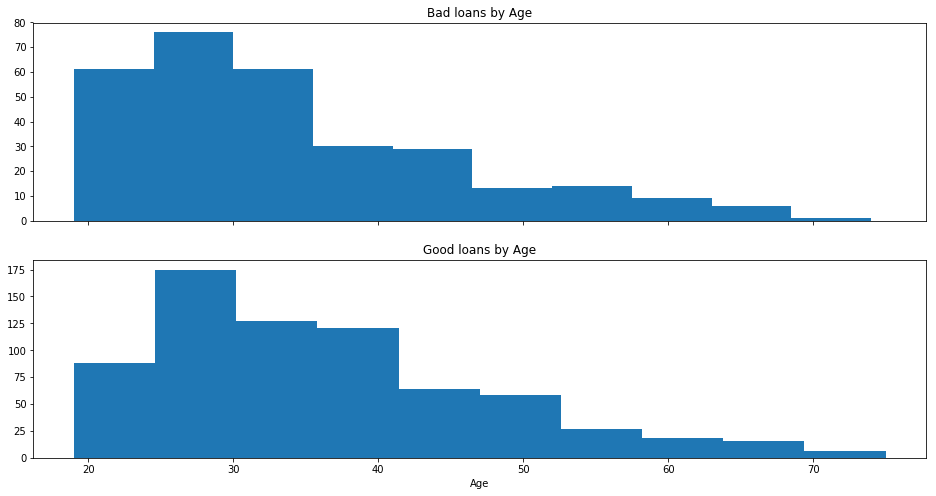

In [0]:
_, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,8))

ax1.hist(data.Age[data.Class == 'Bad'])
ax1.set_title('Bad loans by Age')

ax2.hist(data.Age[data.Class == 'Good'])
ax2.set_title('Good loans by Age')

plt.xlabel('Age')
#plt.ylabel('')
plt.show()

In [0]:
import plotly
import plotly.express as px
import plotly.graph_objects as go

In [0]:
data[data.columns].isnull().sum()

In [0]:
data["Class"].replace('Good',0,inplace=True)
data["Class"].replace('Bad',1,inplace=True)


In [0]:
data.head()

,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,Class,CheckingAccountStatus.lt.0,CheckingAccountStatus.0.to.200,CheckingAccountStatus.gt.200,CheckingAccountStatus.none,CreditHistory.NoCredit.AllPaid,CreditHistory.ThisBank.AllPaid,CreditHistory.PaidDuly,CreditHistory.Delay,CreditHistory.Critical,Purpose.NewCar,Purpose.UsedCar,Purpose.Furniture.Equipment,Purpose.Radio.Television,Purpose.DomesticAppliance,Purpose.Repairs,Purpose.Education,Purpose.Vacation,Purpose.Retraining,Purpose.Business,Purpose.Other,SavingsAccountBonds.lt.100,SavingsAccountBonds.100.to.500,SavingsAccountBonds.500.to.1000,SavingsAccountBonds.gt.1000,SavingsAccountBonds.Unknown,EmploymentDuration.lt.1,EmploymentDuration.1.to.4,EmploymentDuration.4.to.7,EmploymentDuration.gt.7,EmploymentDuration.Unemployed,Personal.Male.Divorced.Seperated,Personal.Female.NotSingle,Personal.Male.Single,Personal.Male.Married.Widowed,Personal.Female.Single,OtherDebtorsGuarantors.None,OtherDebtorsGuarantors.CoApplicant,OtherDebtorsGuarantors.Guarantor,Property.RealEstate,Property.Insurance,Property.CarOther,Property.Unknown,OtherInstallmentPlans.Bank,OtherInstallmentPlans.Stores,OtherInstallmentPlans.None,Housing.Rent,Housing.Own,Housing.ForFree,Job.UnemployedUnskilled,Job.UnskilledResident,Job.SkilledEmployee,Job.Management.SelfEmp.HighlyQualified
0,6,1169,4,4,67,2,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
1,48,5951,2,2,22,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
2,12,2096,2,3,49,1,2,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3,42,7882,2,4,45,1,2,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0


In [0]:
from sklearn.model_selection import train_test_split
  
y=data['Class']

data.shape

type(y)

pandas.core.series.Series

In [0]:
X=data[data.columns[~data.columns.isin(['Class'])]]

X.shape

(1000, 61)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=12)


In [0]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [0]:
Good=data[data['Class']==0]
Bad=data[data['Class']==1]

outlier_fraction=len(Bad)/float(len(Good))
print(outlier_fraction)

print('Good Cases: {}'.format(len(data[data['Class'] == 0])))
print('Bad Transactions: {}'.format(len(data[data['Class'] == 1])))


0.42857142857142855
Good Cases: 700
Bad Transactions: 300


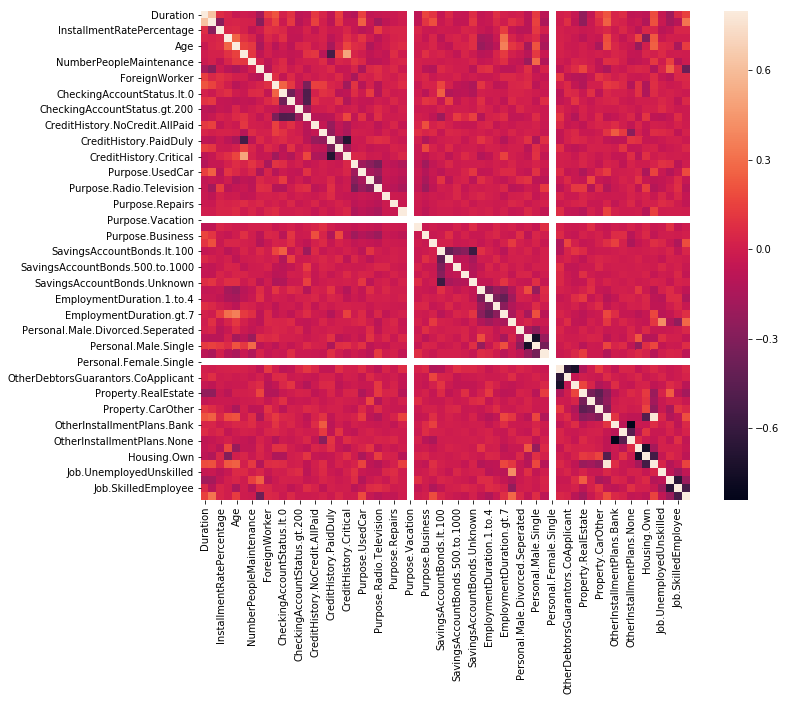

In [0]:
import seaborn as sns
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()


In [0]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we'll be predicting on
target = "Class"

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(1000, 61)
(1000,)


## Random Forest Classifier


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix


In [0]:
rfc = RandomForestClassifier(n_estimators=100)

In [34]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
rfc_preds = rfc.predict(X_test)

In [0]:
#rfc_preds 0 and 1's

In [41]:
y_test.shape

(330,)

In [36]:
print(confusion_matrix(y_test,rfc_preds))

[[210  21]
 [ 63  36]]


In [37]:
print(classification_report(y_test,rfc_preds))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       231
           1       0.63      0.36      0.46        99

    accuracy                           0.75       330
   macro avg       0.70      0.64      0.65       330
weighted avg       0.73      0.75      0.72       330



In [38]:
 print('The accuracy score is: {} '.format(accuracy_score(y_test, rfc_preds)))

The accuracy score is: 0.7454545454545455 


## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression


In [0]:
log = LogisticRegression(random_state=0, solver='liblinear').fit(X_train, y_train)

In [0]:
log_preds=log.predict(X_test) 

In [51]:
log.score(X_test, y_test)

0.7272727272727273

In [55]:
print(classification_report(y_test,log_preds))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       231
           1       0.55      0.52      0.53        99

    accuracy                           0.73       330
   macro avg       0.67      0.67      0.67       330
weighted avg       0.72      0.73      0.72       330



In [0]:
#print(y_pred)

## Local Outlier Factor



In [109]:
# Try different contamination values (proportion of outliers in the data set). Usually should use the outlier_fraction computed above.

for i in (0.01,0.1,0.2,outlier_fraction) : 
  
  clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=i)
  clf.fit(X_train)

  # DO NOT use predict, decision_function and score_samples on X_train as this
  # would give wrong results but only on new unseen data (not used in X_train),
  # e.g. X_test, X_outliers or the meshgrid

  y_pred_test = clf.predict(X_test)
  #y_pred_test
  
  y_pred_test[y_pred_test == 1] = 0
  y_pred_test[y_pred_test == -1] = 1

  n_errors = (y_pred_test != y_test).sum()
  #n_errors

  print('Local Outlier Factor - The number of errors for contamination {} is : {}'.format(i, n_errors))
  print('The accuracy score is: {} '.format(accuracy_score(y_test, y_pred_test)))
  print(classification_report(y_test, y_pred_test))

Local Outlier Factor - The number of errors for contamination 0.01 is : 104
The accuracy score is: 0.6848484848484848 
              precision    recall  f1-score   support

           0       0.70      0.98      0.81       231
           1       0.00      0.00      0.00        99

    accuracy                           0.68       330
   macro avg       0.35      0.49      0.41       330
weighted avg       0.49      0.68      0.57       330

Local Outlier Factor - The number of errors for contamination 0.1 is : 119
The accuracy score is: 0.6393939393939394 
              precision    recall  f1-score   support

           0       0.69      0.88      0.77       231
           1       0.22      0.08      0.12        99

    accuracy                           0.64       330
   macro avg       0.46      0.48      0.45       330
weighted avg       0.55      0.64      0.58       330

Local Outlier Factor - The number of errors for contamination 0.2 is : 125
The accuracy score is: 0.621212121

In [0]:
type(y)

pandas.core.series.Series

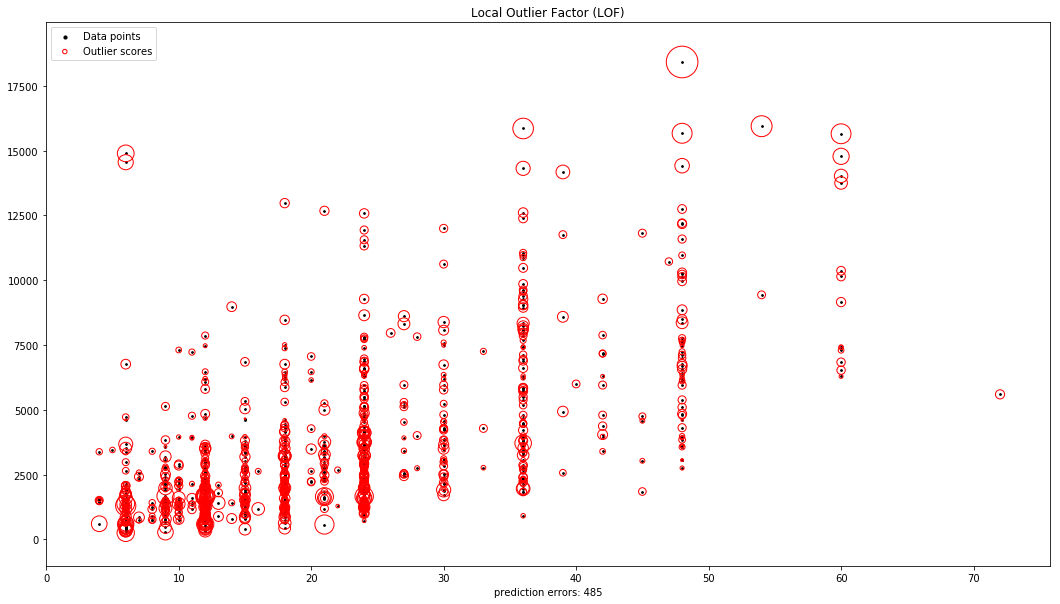

In [0]:
plt.figure(figsize=(18,10))

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (scores_pred.max() - scores_pred) / (scores_pred.max() - scores_pred.min())
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')

plt.axis('tight')

# plt.xlim((-50, 50000))
# plt.ylim((-50, 50000))

plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()


In [0]:
type(y_pred)

numpy.ndarray

##Isolation Forest

In [0]:
for i in (0.01,0.1,0.2,outlier_fraction) : 
  
  clf = IsolationForest(max_samples=len(X),contamination=i,random_state=1)
  clf.fit(X)
  scores_pred = clf.decision_function(X)
  y_pred = clf.predict(X)
  
  y_pred[y_pred == 1] = 0
  y_pred[y_pred == -1] = 1

  n_errors = (y_pred != y).sum()
  #n_errors

  print('Isolation Forest- The number of errors for contamination {} is : {}'.format(i, n_errors))
  print('The accuracy score is: {} '.format(accuracy_score(y, y_pred)))
  print(classification_report(y, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



Isolation Forest- The number of errors for contamination 0.01 is : 302
The accuracy score is: 0.698 
              precision    recall  f1-score   support

           0       0.70      0.99      0.82       700
           1       0.40      0.01      0.03       300

    accuracy                           0.70      1000
   macro avg       0.55      0.50      0.42      1000
weighted avg       0.61      0.70      0.58      1000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



Isolation Forest- The number of errors for contamination 0.1 is : 318
The accuracy score is: 0.682 
              precision    recall  f1-score   support

           0       0.71      0.92      0.80       700
           1       0.41      0.14      0.20       300

    accuracy                           0.68      1000
   macro avg       0.56      0.53      0.50      1000
weighted avg       0.62      0.68      0.62      1000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning:

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.



Isolation Forest- The number of errors for contamination 0.2 is : 334
The accuracy score is: 0.666 
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       700
           1       0.41      0.28      0.33       300

    accuracy                           0.67      1000
   macro avg       0.57      0.55      0.55      1000
weighted avg       0.63      0.67      0.64      1000

Isolation Forest- The number of errors for contamination 0.42857142857142855 is : 419
The accuracy score is: 0.581 
              precision    recall  f1-score   support

           0       0.75      0.61      0.67       700
           1       0.36      0.52      0.43       300

    accuracy                           0.58      1000
   macro avg       0.55      0.56      0.55      1000
weighted avg       0.63      0.58      0.60      1000



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning:

threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.

